In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Function():
    # x : numpy.ndarray
    h = 1e-4
    def __init__(self):
        return

    def f(self, w, others):
        # It must be overridden
        # w : need grad
        # others : do not need grad
        return w

    def grad(self, w, others):
        # may be overridden if f' can be solved analytically
        tmp = 0
        grads = np.zeros_like(w, dtype=float)
        for i in range(w.size):
            tmp = w[i]
            w[i] = tmp - self.h
            fx1 = self.f(w, others)
            w[i] = tmp + self.h
            fx2 = self.f(w, others)
            grads[i] = (fx2-fx1)/(2*self.h)
            w[i] = tmp

        return grads

    def hessian(self, w, others):
        tmp = 0
        hessians = np.zeros([w.size, w.size], dtype=float)
        for i in range(w.size):
            tmp = w[i]
            w[i] = tmp - self.h
            grads1 = self.grad(w, others)
            w[i] = tmp + self.h
            grads2 = self.grad(w, others)
            hessians[:, i] = (grads2-grads1)/(2*self.h)
            w[i] = tmp

        return hessians

In [3]:
class Optimizer():
    def __init__(self, max_step):
        self.param_history = []
        self.func_history = []
        self.max_step = max_step
    
    def clear(self):
        self.param_history = []
        self.func_history = []

    def PG(self, function, w, others, r):
        # PG : proximal gradient method
        # function : Function
        # r : stop condition
        self.clear()
        tmp = np.copy(w)
        self.param_history.append(tmp)
        self.func_history.append(function.f(tmp, others))
        count = 0
        while count <= self.max_step:
            grads = function.grad(tmp, others)
            tmp = tmp - function.eta*grads
            tmp = soft_threshold(others[0]*function.eta, tmp)
            self.param_history.append(tmp)
            self.func_history.append(function.f(tmp, others))
            if np.linalg.norm(grads, ord=2) < r:
                break
            count +=1
        return tmp
            

In [4]:
class P2F(Function):
    def __init__(self, A, mu):
        self.A = A
        self.mu = mu
        w, _ = np.linalg.eig(2*A)
        self.eta = 1/w.max()
        return

    def f(self, w, others):
        lamb = others[0]
        return np.dot(np.dot((w-self.mu).T, self.A), (w-self.mu)) + lamb * np.linalg.norm(w, ord=1)

    def grad(self, w, others):
        return 2*np.dot(self.A, (w-self.mu))


In [5]:
def soft_threshold(t, x):
    # x : np.ndarray
    res = np.zeros_like(x)
    for i in range(x.size):
        if x[i] >= t:
            res[i] = x[i]-t
        elif x[i] <= -t:
            res[i] = x[i]+t
        else:
            res[i] =  0

    return res

def plot_result(histories, title, lambdas):
    # histories : [[param_history, func_history], [param_history, func_history], ...]
    fig,ax = plt.subplots()
    for i in range(len(lambdas)):
        param_diff = [ ph-histories[i][0][-1] for ph in histories[i][0]]
        param_diff = [ np.linalg.norm(pd, ord=2) for pd in param_diff ]
        ax.plot(list(range(len(histories[i][0]))), param_diff, label=('lambda = '+str(lambdas[i])))
    ax.set_title(title)
    ax.set_yscale('log')
    ax.legend()
    plt.show()

In [6]:
A = np.array([[3, 0.5], [0.5, 1]])
mu = np.array([1, 2])
lambdas = [2, 4, 6]
np.random.seed(0)
w = np.random.rand(2)

In [7]:
p2f = P2F(A, mu)
opt = Optimizer(1024)

In [8]:
histories = []
w_opts = []
for l in lambdas:
    w_opt = opt.PG(p2f, w, [l], 0.01)
    histories.append([opt.param_history, opt.func_history])
    w_opts.append(w_opt)

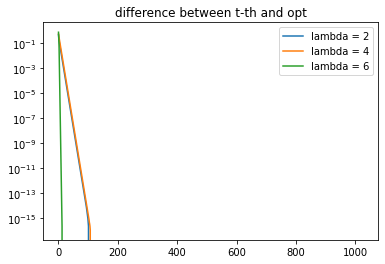

In [9]:
plot_result(histories, 'difference between t-th and opt', lambdas) 

In [10]:
print(w_opts)

[array([0.81818182, 1.09090909]), array([0.63636364, 0.18181818]), array([0.33333333, 0.        ])]
